In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params,fit2,dravnieks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr,spearmanr
import scipy.io as sio
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPRegressor

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dream_CIDs = loading.get_CIDs(['training','leaderboard','testset'])
dream_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard','testset'])

In [3]:
df_dream = loading.load_perceptual_data(['training','leaderboard','testset'])
# Average over replicates, then pick lowest dilution
low_dilutions = df_dream.sort_index(level=['Descriptor','CID','Dilution']).groupby(level=['Descriptor','CID','Dilution'])\
                        .mean().fillna(999).groupby(level=['Descriptor','CID']).last().replace(999,float('NaN'))
descriptors = loading.get_descriptors(format=True)

In [4]:
dream_features = loading.get_molecular_data(['dragon','morgan'],dream_CIDs)

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7306 total features.


In [33]:
# Reviewer issues 2.10 and 2.11
def feature_correlation(feature,descriptor):
    X = dream_features[feature].loc[dream_CIDs]
    Y = low_dilutions.loc[descriptor].mean(skipna=True,axis=1)
    r,p = pearsonr(X,Y)
    print("Correlation between %s and %s is %.3f (p=%.3g)" % (feature,descriptor,r,p))
    
feature_correlation(('dragon','nS'),'Garlic')
feature_correlation(('dragon','nS'),'Burnt')
feature_correlation(('dragon','MW'),'Pleasantness')
feature_correlation(('morgan','36314'),'Pleasantness')
feature_correlation(('morgan','8767'),'Pleasantness')
feature_correlation(('morgan','1183'),'Bakery')

Correlation between ('dragon', 'nS') and Garlic is 0.661 (p=4.03e-61)
Correlation between ('dragon', 'nS') and Burnt is 0.413 (p=5.28e-21)
Correlation between ('dragon', 'MW') and Pleasantness is 0.160 (p=0.00044)
Correlation between ('morgan', '36314') and Pleasantness is 0.184 (p=5.15e-05)
Correlation between ('morgan', '8767') and Pleasantness is 0.178 (p=9.43e-05)
Correlation between ('morgan', '1183') and Bakery is 0.450 (p=4.62e-25)


In [7]:
drav_cas = pd.read_table(os.path.join('../../data','dravnieks_cas.txt'),delimiter=' ',index_col=0)
drav_descriptors = pd.read_table(os.path.join('../../data','dravnieks_descriptors.txt'),index_col=None,header=0,names=['Descriptor'])
drav_descriptors['Descriptor'] = [' '.join(x.split(' ')[1:]) for x in drav_descriptors['Descriptor']]
drav_data_raw = sio.loadmat(os.path.join('../../data','dravnieks.mat'))
drav_data = pd.DataFrame(drav_data_raw['pu'].T,index=drav_cas['C.A.S.'],columns=drav_descriptors['Descriptor'])
drav_cas_cid = pd.read_table(os.path.join('../../data','dravnieks_cas_cid.txt'),header=None,index_col=0,names=['CID'])
drav_cas_cid[:] = drav_cas_cid.values.astype(int)
drav_cas_cid.index.name = 'C.A.S.'
drav_data = drav_data.join(drav_cas_cid,how='left').set_index('CID') # Join with CIDs
drav_data.drop_duplicates(inplace=True) # Remove duplicate data
drav_data = drav_data[drav_data.index>0]#.sort_index() # Remove negative indices
drav_data = drav_data.groupby(level='CID').first() # Remove duplicate indices
drav_data.head()

,"FRUITY, CITRUS",LEMON,GRAPEFRUIT,ORANGE,"FRUITY, OTHER THAN CITRUS",PINEAPPLE,GRAPE JUICE,STRAWBERRY,APPLE (FRUIT),PEAR,...,"PUTRID, FOUL, DECAYED",FECAL (LIKE MANURE),CADAVEROUS (DEAD ANIMAL),SICKENING,"DRY, POWDERY",CHALKY,LIGHT,HEAVY,"COOL, COOLING",WARM
CID,,,,,,,,,,,,,,,,,,,,,
240,5.04,3.60,0.72,1.44,22.30,2.16,0.72,5.76,0.00,1.44,...,0.72,0.00,0.00,5.04,5.04,0.72,20.86,27.34,13.67,21.58
264,0.00,0.71,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,...,47.86,35.00,13.57,65.71,1.43,0.00,2.86,38.57,0.00,11.43
323,2.86,3.57,0.00,0.00,14.29,3.57,0.71,2.86,1.43,0.71,...,3.57,0.00,0.00,7.14,7.86,1.43,24.29,13.57,12.14,20.71
326,10.71,16.43,2.14,5.00,7.14,1.43,0.00,2.14,0.00,2.14,...,6.43,0.00,0.71,20.00,12.14,2.14,16.43,24.29,14.29,17.86
342,0.00,0.00,0.00,0.00,2.16,0.72,0.00,0.00,0.00,0.72,...,2.88,4.32,2.16,14.39,12.95,0.00,12.23,24.46,7.19,14.39


In [8]:
dream_data = low_dilutions.mean(skipna=True,axis=1).unstack('Descriptor')[descriptors]
dream_data.head()

Descriptor,Intensity,Pleasantness,Bakery,Sweet,Fruit,Fish,Garlic,Spices,Cold,Sour,...,Acid,Warm,Musky,Sweaty,Ammonia,Decayed,Wood,Grass,Flower,Chemical
CID,,,,,,,,,,,,,,,,,,,,,
126,49.551020,48.956522,0.630435,24.347826,6.239130,0.282609,1.608696,3.652174,4.000000,7.500000,...,2.847826,0.913043,8.304348,1.500000,1.804348,4.978261,1.260870,1.347826,9.260870,14.239130
176,11.551020,48.461538,2.538462,6.692308,1.230769,0.000000,7.192308,8.230769,5.769231,15.307692,...,3.500000,4.230769,6.769231,7.153846,3.615385,3.038462,1.807692,1.961538,4.115385,3.384615
177,33.265306,45.315789,8.421053,20.078947,1.763158,0.000000,0.631579,2.500000,7.000000,10.447368,...,4.447368,4.526316,3.421053,1.947368,3.789474,3.263158,1.026316,4.000000,2.184211,18.789474
180,16.714286,55.437500,3.375000,15.531250,6.468750,2.281250,2.593750,4.375000,7.625000,9.031250,...,3.218750,10.031250,7.531250,0.031250,5.281250,6.218750,8.625000,6.593750,12.625000,10.500000
196,22.183673,53.218750,1.750000,18.312500,1.312500,0.000000,1.906250,6.156250,5.562500,6.218750,...,3.218750,9.437500,6.781250,6.093750,2.781250,6.906250,1.187500,2.218750,9.625000,7.750000


In [9]:
shared_CIDs = list(set(dream_data.index).intersection(drav_data.index))
print("There are %d molecules in common between DREAM and Dravnieks" % len(shared_CIDs))
unshared_CIDs = list(set(drav_data.index).difference(dream_data.index))
print("There are %d molecules in Dravnieks that are not in DREAM" % len(unshared_CIDs))

There are 58 molecules in common between DREAM and Dravnieks


In [40]:
#import urllib
#for CID in unshared_CIDs:
#    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%d/record/SDF/?record_type=3d&response_type=save&response_basename=Structure3D_CID_%d" % (CID,CID)
#    try:
#        urllib.request.urlretrieve(url, '/Users/rgerkin/Desktop/sdf/%d.sdf' % CID)
#    except:
#        print("%d not found" % CID)

In [18]:
drav_cas_cid

,CID
C.A.S.,
698-10-2,61199
98-86-2,7410
1122-62-9,14286
141-13-9,98403
77-83-8,6501
77-83-8,6501
104-61-0,7710
123-68-2,31266
540-18-1,10890


In [19]:
for dream_desc,drav_desc in [('Sweet','SWEET'),('Garlic','GARLIC, ONION'),('Bakery','VANILLA')]:
    d1 = dream_data[dream_desc].loc[shared_CIDs]
    d2 = drav_data[drav_desc].loc[shared_CIDs]
    pr = pearsonr(d1,d2)[0]
    sr = spearmanr(d1,d2)[0]
    print('%.2f (%.2f): %s vs %s' % (pr,sr,dream_desc,drav_desc))

0.82 (0.86): Sweet vs SWEET
0.80 (0.54): Garlic vs GARLIC, ONION
0.82 (0.51): Bakery vs VANILLA


In [20]:
rs = pd.DataFrame(index=drav_data.columns,columns=descriptors)
ps = pd.DataFrame(index=drav_data.columns,columns=descriptors)
for dream_desc in descriptors:
    d1 = dream_data[dream_desc].loc[shared_CIDs]
    for drav_desc in drav_data.columns:
        d2 = drav_data[drav_desc].loc[shared_CIDs]
        rs.loc[drav_desc,dream_desc],ps.loc[drav_desc,dream_desc] = pearsonr(d1,d2)
    ps.loc[:,dream_desc] *= 146/(146-np.argsort(ps.loc[:,dream_desc]))

In [21]:
top_matches = pd.concat([rs.idxmax(),rs.max().round(3)],axis=1)
top_matches.columns = ['Dravnieks','r']
top_matches

,Dravnieks,r
Intensity,SOUR MILK,0.256
Pleasantness,FRAGRANT,0.713
Bakery,MALTY,0.831
Sweet,SWEET,0.824
Fruit,PEACH (FRUIT),0.817
Fish,SAUERKRAUT,0.821
Garlic,SULFIDIC,0.818
Spices,CLOVE,0.747
Cold,"COOL, COOLING",0.617
Sour,SOUR MILK,0.853


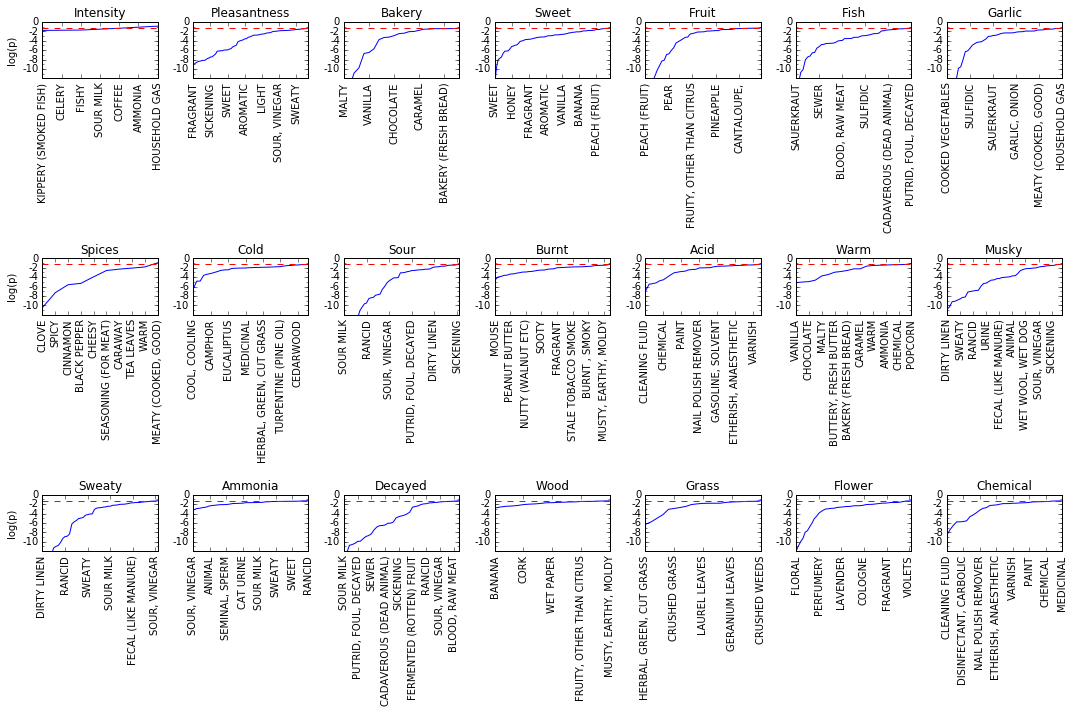

In [25]:
n_dream_desc = len(descriptors)
n_drav_desc = len(drav_descriptors)
fig,axes = plt.subplots(3,7,figsize=(15,10))
for i,ax in enumerate(axes.flat):
    ax.plot(range(n_drav_desc),sorted(ps.loc[:,descriptors[i]]))
    ax.plot([0,n_drav_desc],[0,0],'--')
    alpha = 0.05
    num_sig = (ps.loc[:,descriptors[i]]<=alpha).sum()
    ax.plot([0,max(1,num_sig)],[alpha,alpha],'--')
    ax.set_xticklabels(list(drav_data.columns[np.argsort(ps.loc[:,descriptors[i]])]),rotation=90)
    ax.set_xlim(0,max(1,num_sig))
    ax.set_yscale('log')
    ax.set_yticks(np.logspace(-10,0,6))
    ax.set_yticklabels(np.linspace(-10,0,6).astype(int))
    ax.set_ylim(1e-12,1)
    ax.set_title(descriptors[i])
    if i%7 == 0:
        ax.set_ylabel("log(p)")
#fig.subplots_adjust(hspace=2,wspace=0.5)
plt.tight_layout()

In [32]:
n_splits = 25
ss = ShuffleSplit(n_splits,test_size=0.2,random_state=0)
dream_data = low_dilutions.mean(skipna=True,axis=1).unstack('Descriptor')[descriptors]
class NNLS:
    def fit(self,X,y):
        self.coefs,residual = nnls(X,y)
    def predict(self,X):
        return np.dot(X,self.coefs)
clfs = {'cca':CCA(n_components=1, scale=False, max_iter=500, tol=1e-06, copy=True),
        'rfr':RandomForestRegressor(n_estimators=50,max_features=None,max_depth=None),
        #'nnls':NNLS()
       }
rs_in = {clf:np.zeros(len(descriptors)) for clf in clfs}
rs_out = {clf:np.zeros((len(descriptors),n_splits)) for clf in clfs}
for j in range(len(descriptors)):
    print(descriptors[j])
    for name,clf in clfs.items():
        clf.fit(drav_data.loc[shared_CIDs],dream_data.loc[shared_CIDs].values[:,j])
        rs_in[name][j] = np.corrcoef(clf.predict(drav_data.loc[shared_CIDs]).squeeze(),dream_data.loc[shared_CIDs].values[:,j])[0,1]
        for i,(train,test) in enumerate(ss.split(shared_CIDs)):
            train = np.array(shared_CIDs)[train]
            test = np.array(shared_CIDs)[test]
            clf.fit(drav_data.loc[train],dream_data.loc[train].values[:,j])
            rs_out[name][j,i] = np.corrcoef(clf.predict(drav_data.loc[test]).squeeze(),dream_data.loc[test].values[:,j])[0,1]

Intensity
Pleasantness
Bakery
Sweet
Fruit
Fish
Garlic
Spices
Cold
Sour
Burnt
Acid
Warm
Musky
Sweaty
Ammonia
Decayed
Wood
Grass
Flower
Chemical


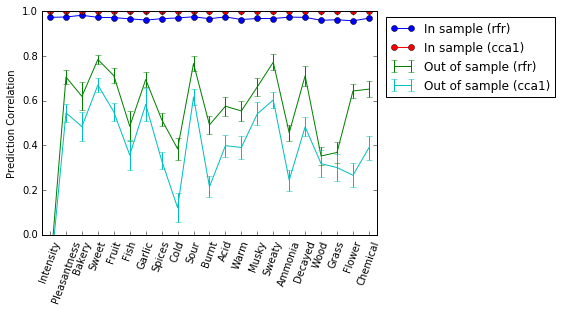

In [27]:
for name in clfs:
    plt.plot(range(21),rs_in[name],'-o',label='In sample (%s)' % name)
    plt.errorbar(range(21),rs_out[name].mean(axis=1),rs_out[name].std(axis=1)/np.sqrt(n_splits),label='Out of sample (%s)' % name)
plt.xticks(range(21),descriptors,rotation=70)
plt.xlim(-0.5,20.5)
plt.ylim(0,1)
plt.ylabel('Prediction Correlation')
plt.legend(bbox_to_anchor=(1.55, 1))

In [28]:
cca_coefs = pd.DataFrame(index=drav_data.columns,columns=descriptors)
cca = CCA(n_components=1, scale=False, max_iter=500, tol=1e-06, copy=True)
for j in range(len(descriptors)):
    X = drav_data.loc[shared_CIDs]
    y = dream_data.loc[shared_CIDs].values[:,j]
    cca.fit(X,y)
    cca_coefs[descriptors[j]] = cca.coef_

In [29]:
from scipy.optimize import nnls
nnls_coefs = pd.DataFrame(index=drav_data.columns,columns=descriptors)
for j in range(len(descriptors)):
    X = drav_data.loc[shared_CIDs]
    y = dream_data.loc[shared_CIDs].values[:,j]
    coefs,residual = nnls(X,y)
    nnls_coefs[descriptors[j]] = coefs

In [30]:
for descriptor in descriptors:
    print(descriptor,nnls_coefs[descriptor].idxmax())

Intensity EGGY (FRESH EGGS)
Pleasantness GREEN PEPPER
Bakery BAKERY (FRESH BREAD)
Sweet RAISINS
Fruit GRAPEFRUIT
Fish SAUERKRAUT
Garlic SAUERKRAUT
Spices CARAWAY
Cold MUSHROOM
Sour SEMINAL, SPERM
Burnt MOUSE
Acid EGGY (FRESH EGGS)
Warm BAKERY (FRESH BREAD)
Musky BEANY
Sweaty SEMINAL, SPERM
Ammonia SEMINAL, SPERM
Decayed SOUR MILK
Wood RAW CUCUMBER
Grass LAUREL LEAVES
Flower BEERY
Chemical EGGY (FRESH EGGS)


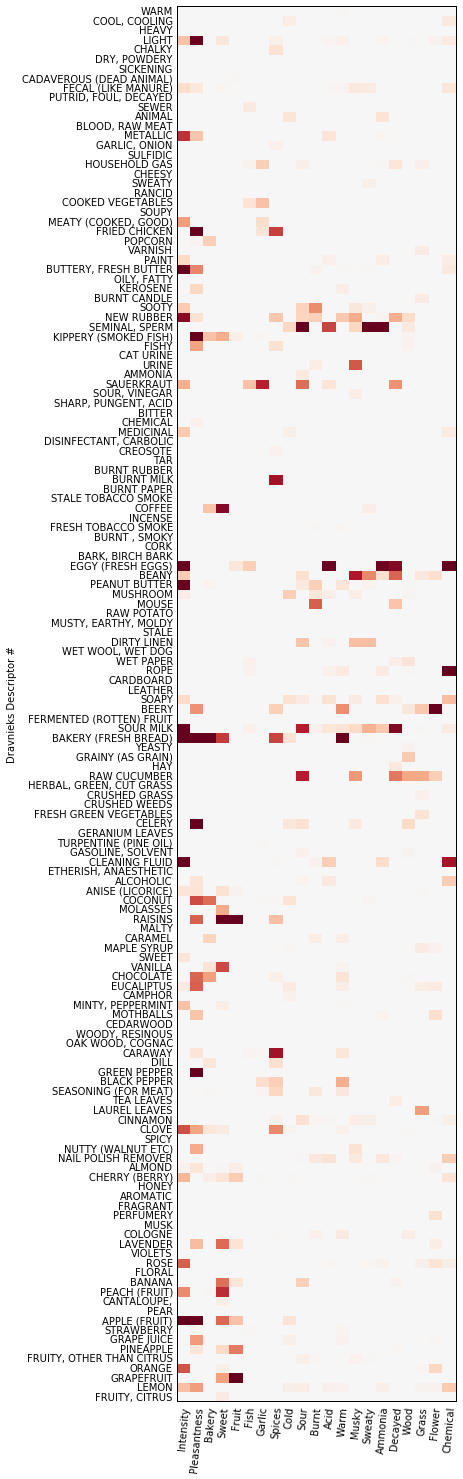

In [73]:
plt.figure(figsize=(5,25))
plt.pcolor(nnls_coefs,vmin=-1,vmax=1,cmap='RdBu_r')
plt.xlim(0,21)
plt.xticks(np.arange(21)+0.5,descriptors,rotation=85)
plt.ylim(0,146)
plt.yticks(np.arange(0,146)+0.5,list(drav_data.columns))
plt.ylabel('Dravnieks Descriptor #')
plt.tick_params(length=0)